In [ ]:
import pandas as pd
import numpy as np

file_names = [
    'Cities.csv',
    'Conferences.csv',
    'MConferenceTourneyGames.csv',
    'MGameCities.csv',
    'MMasseyOrdinals.csv',
    'MNCAATourneyCompactResults.csv',
    'MNCAATourneyDetailedResults.csv',
    'MNCAATourneySeedRoundSlots.csv',
    'MNCAATourneySeeds.csv',
    'MNCAATourneySlots.csv',
    'MRegularSeasonCompactResults.csv',
    'MRegularSeasonDetailedResults.csv',
    'MSeasons.csv',
    'MSecondaryTourneyCompactResults.csv',
    'MSecondaryTourneyTeams.csv',
    'MTeamCoaches.csv',
    'MTeamConferences.csv',
    'MTeamSpellings.csv',
    'MTeams.csv',
    'SampleSubmissionStage1.csv',
    'SampleSubmissionStage2.csv',
    'SeedBenchmarkStage1.csv',
    'WConferenceTourneyGames.csv',
    'WGameCities.csv',
    'WNCAATourneyCompactResults.csv',
    'WNCAATourneyDetailedResults.csv',
    'WNCAATourneySeeds.csv',
    'WNCAATourneySlots.csv',
    'WRegularSeasonCompactResults.csv',
    'WRegularSeasonDetailedResults.csv',
    'WSeasons.csv',
    'WSecondaryTourneyCompactResults.csv',
    'WSecondaryTourneyTeams.csv',
    'WTeamConferences.csv',
    'WTeamSpellings.csv',
    'WTeams.csv'
]

dataframes = {}

for file in file_names:
    key = file.replace('.csv', '')
    dataframes[key] = pd.read_csv(f'data/{file}')

In [2]:
regular_season_df = dataframes['MRegularSeasonDetailedResults']

# Function to estimate possessions
def calculate_possessions(row, team_prefix):
    fga = row[f'{team_prefix}FGA']
    fta = row[f'{team_prefix}FTA']
    to = row[f'{team_prefix}TO']
    orb = row[f'{team_prefix}OR']
    # Approximate opponent's defensive rebounds
    opp_drb = row['LDR'] if team_prefix == 'W' else row['WDR']
    return fga - orb + to + 0.4 * fta

# Calculate possessions for both teams
regular_season_df['WPoss'] = regular_season_df.apply(lambda row: calculate_possessions(row, 'W'), axis=1)
regular_season_df['LPoss'] = regular_season_df.apply(lambda row: calculate_possessions(row, 'L'), axis=1)
regular_season_df['Poss'] = (regular_season_df['WPoss'] + regular_season_df['LPoss']) / 2

# Separate winners and losers, renaming columns consistently
winners = regular_season_df[['Season', 'WTeamID', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WScore', 'Poss', 'LScore']]
losers = regular_season_df[['Season', 'LTeamID', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LScore', 'Poss', 'WScore']]
winners.columns = ['Season', 'TeamID', 'FGM', 'FGA', 'FGM3', 'FGA3', 'Score', 'Poss', 'OppScore']
losers.columns = ['Season', 'TeamID', 'FGM', 'FGA', 'FGM3', 'FGA3', 'Score', 'Poss', 'OppScore']

# Combine into one dataframe
all_teams = pd.concat([winners, losers], ignore_index=True)

# Aggregate by season and team
team_season_stats = all_teams.groupby(['Season', 'TeamID']).mean().reset_index()

# Calculate derived metrics
team_season_stats['3PA_rate'] = team_season_stats['FGA3'] / team_season_stats['FGA']
team_season_stats['3P_pct'] = team_season_stats['FGM3'] / team_season_stats['FGA3']
team_season_stats['Pace'] = team_season_stats['Poss']
team_season_stats['Off_Eff'] = (team_season_stats['Score'] / team_season_stats['Poss']) * 100
team_season_stats['Def_Eff'] = (team_season_stats['OppScore'] / team_season_stats['Poss']) * 100

# Select relevant columns
metrics = ['3PA_rate', '3P_pct', 'Pace', 'Off_Eff', 'Def_Eff']
team_season_stats = team_season_stats[['Season', 'TeamID'] + metrics]

# Preview the result
print(team_season_stats.head())

   Season  TeamID  3PA_rate    3P_pct       Pace     Off_Eff     Def_Eff
0    2003    1102  0.523339  0.375643  53.682143  106.646264  106.180560
1    2003    1103  0.287798  0.338710  69.100000  114.005467  113.094281
2    2003    1104  0.347283  0.320144  65.292857  106.115305   99.551471
3    2003    1105  0.337079  0.364815  74.942308   95.765974  102.283808
4    2003    1106  0.319121  0.346154  66.275000   95.974565   96.190117


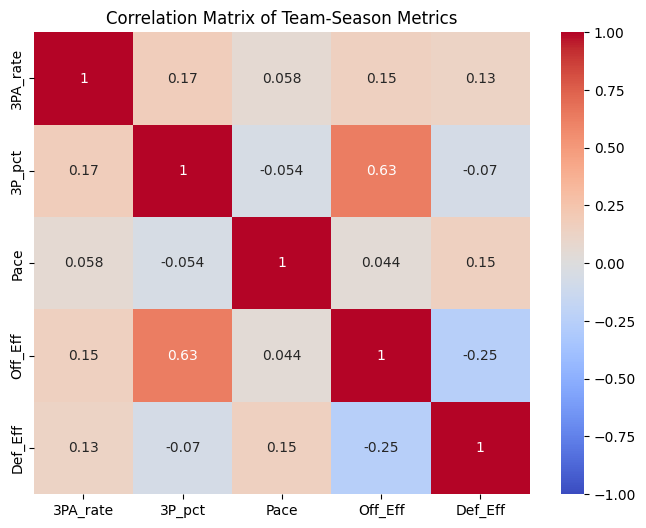

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = team_season_stats[metrics].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)    
plt.title('Correlation Matrix of Team-Season Metrics')
plt.savefig('figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

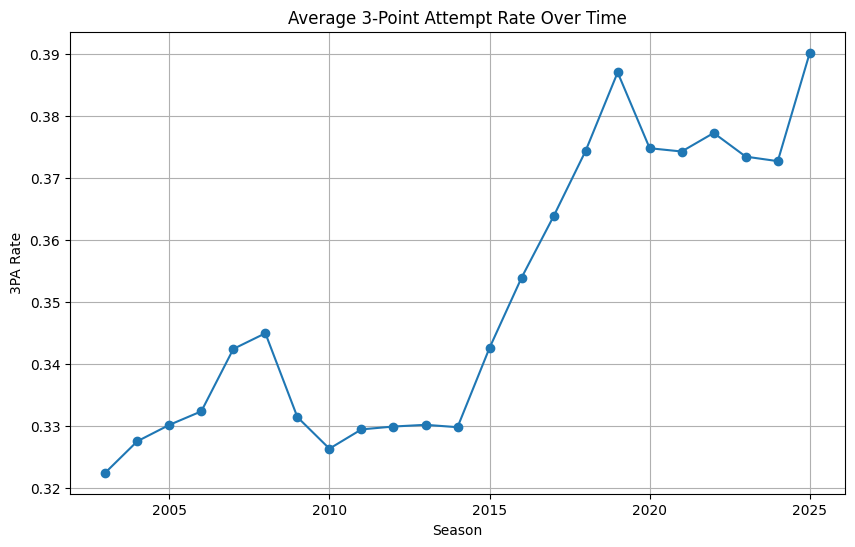

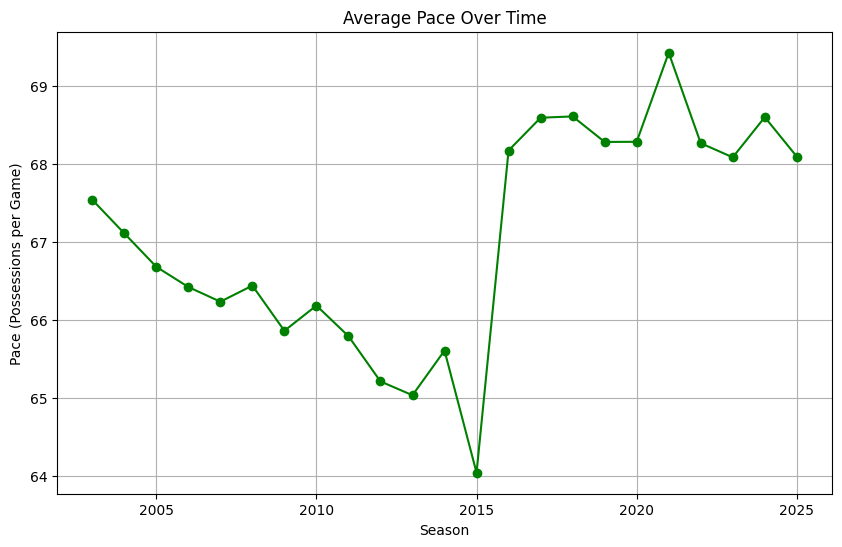

In [4]:
# Calculate season averages
season_trends = team_season_stats.groupby('Season')[metrics].mean().reset_index()

# Plot 3PA_rate over time
plt.figure(figsize=(10, 6))
plt.plot(season_trends['Season'], season_trends['3PA_rate'], marker='o')
plt.title('Average 3-Point Attempt Rate Over Time')
plt.xlabel('Season')
plt.ylabel('3PA Rate')
plt.grid(True)
plt.savefig('figures/3pa_rate_trend.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot Pace over time
plt.figure(figsize=(10, 6))
plt.plot(season_trends['Season'], season_trends['Pace'], marker='o', color='green')
plt.title('Average Pace Over Time')
plt.xlabel('Season')
plt.ylabel('Pace (Possessions per Game)')
plt.grid(True)
plt.savefig('figures/pace_trend.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

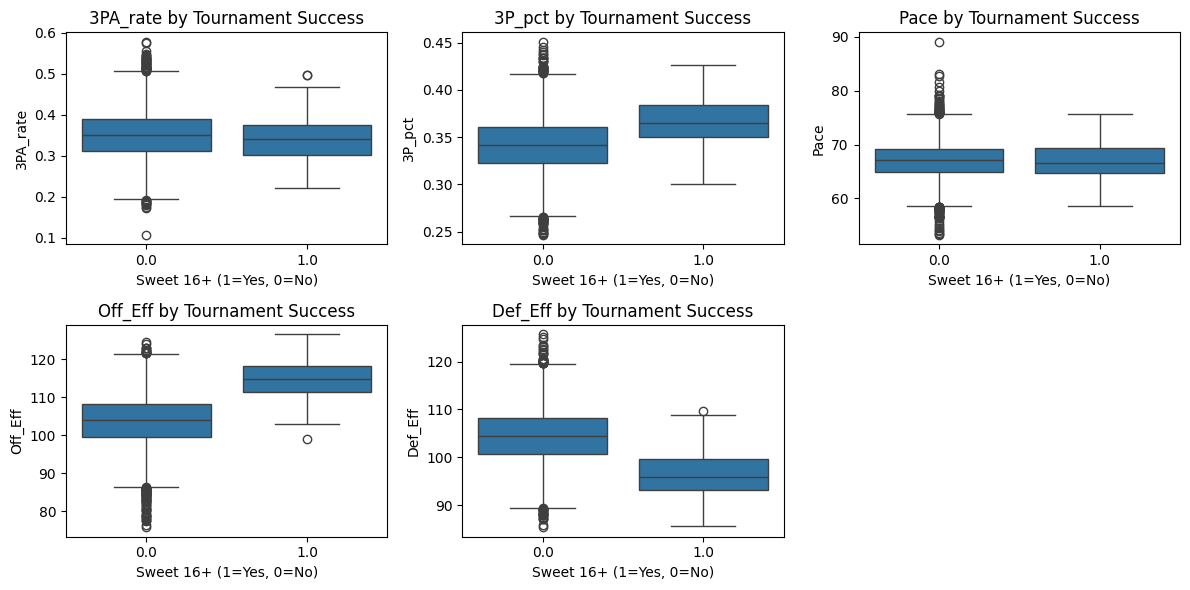

In [5]:
# Load tournament results
tourney_df = dataframes['MNCAATourneyCompactResults']

# Identify teams reaching Sweet 16 or beyond
sweet16_teams = tourney_df[tourney_df['DayNum'] >= 143][['Season', 'WTeamID']].rename(columns={'WTeamID': 'TeamID'})
sweet16_teams['Success'] = 1

# Merge with team-season stats
analysis_df = team_season_stats.merge(sweet16_teams, on=['Season', 'TeamID'], how='left')
analysis_df['Success'] = analysis_df['Success'].fillna(0)

# Compare distributions using boxplots
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Success', y=metric, data=analysis_df)
    plt.title(f'{metric} by Tournament Success')
    plt.xlabel('Sweet 16+ (1=Yes, 0=No)')
plt.tight_layout()
plt.savefig('figures/boxplots_success.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

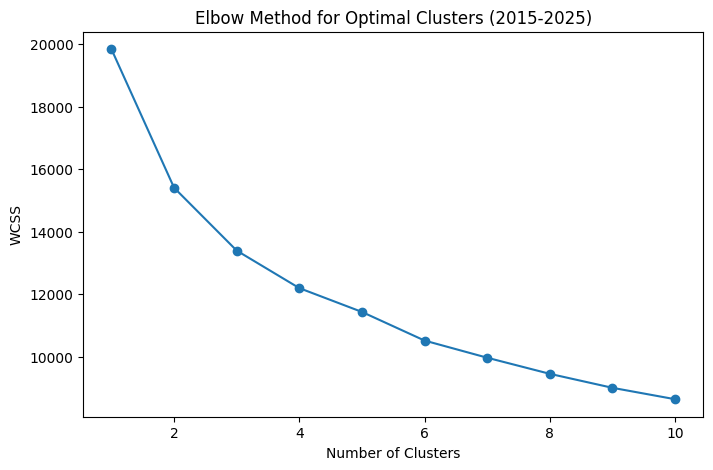

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Filter data for 2015-2025 era
era_df = analysis_df[(analysis_df['Season'] >= 2015) & (analysis_df['Season'] <= 2025)].copy()
metrics = ['3PA_rate', '3P_pct', 'Pace', 'Off_Eff', 'Def_Eff']

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(era_df[metrics])

# Calculate WCSS for 1 to 10 clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters (2015-2025)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('figures/elbow_plot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

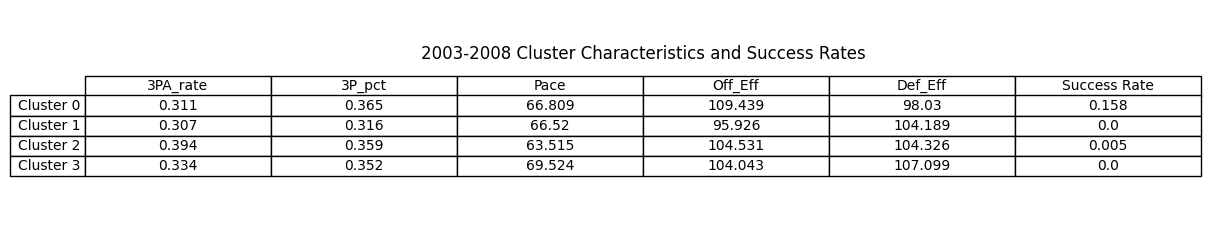

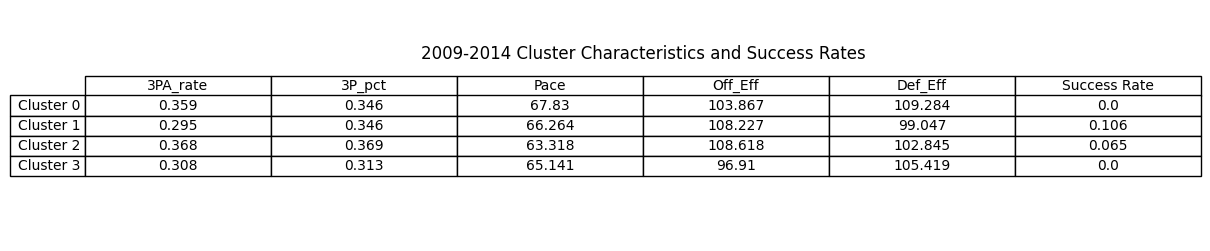

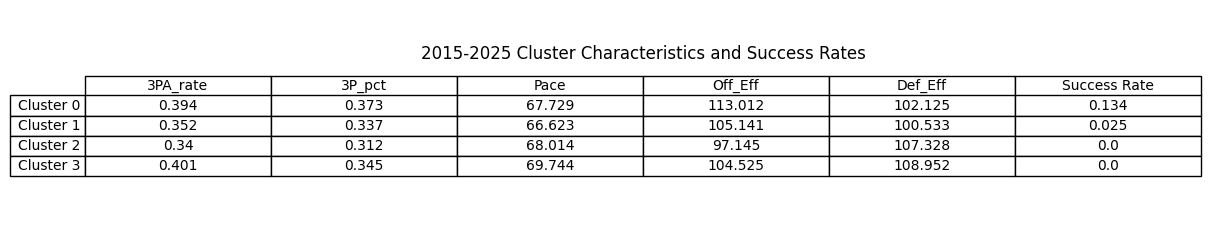

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Define metrics and eras
metrics = ['3PA_rate', '3P_pct', 'Pace', 'Off_Eff', 'Def_Eff']
eras = {
    '2003-2008': (2003, 2008),
    '2009-2014': (2009, 2014),
    '2015-2025': (2015, 2025)
}

def cluster_era(df, era_name, start, end, n_clusters=4):
    # Filter data for the specified era
    era_df = df[(df['Season'] >= start) & (df['Season'] <= end)].copy()
    
    # Check if era_df is empty
    if era_df.empty:
        print(f"No data for {era_name}")
        return None
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(era_df[metrics])
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    era_df['Cluster'] = kmeans.fit_predict(scaled_data)
    
    # Create cluster centers DataFrame
    centers_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=metrics)
    centers_df = centers_df.round(3)
    
    # Calculate success rates
    success_rates = era_df.groupby('Cluster')['Success'].mean().round(3)
    
    # Combine cluster centers and success rates
    combined_df = centers_df.copy()
    combined_df['Success Rate'] = success_rates.values
    
    # Plot combined table
    plt.figure(figsize=(12, 3))
    plt.axis('off')
    table = plt.table(cellText=combined_df.values,
                      colLabels=combined_df.columns,
                      rowLabels=[f'Cluster {i}' for i in range(len(combined_df))],
                      loc='center',
                      cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(f'{era_name} Cluster Characteristics and Success Rates', y=0.75)
    plt.savefig(f'figures/clusters_success_{era_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return era_df

# Perform clustering for each era
clustered_dfs = {}
for era_name, (start, end) in eras.items():
    clustered_df = cluster_era(analysis_df, era_name, start, end)
    if clustered_df is not None:
        clustered_dfs[era_name] = clustered_df

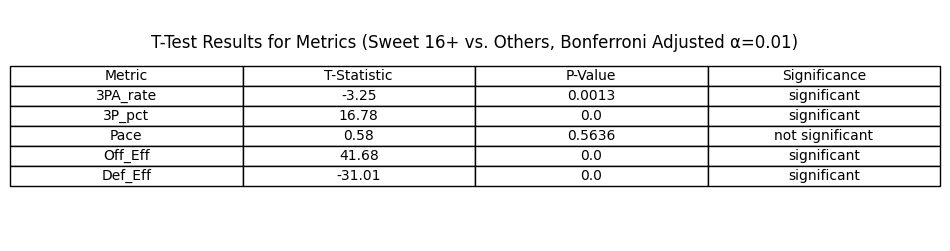

In [ ]:
from scipy.stats import ttest_ind

metrics = ['3PA_rate', '3P_pct', 'Pace', 'Off_Eff', 'Def_Eff']
alpha = 0.05
adjusted_alpha = alpha / len(metrics)

results = []
for metric in metrics:
    winners = analysis_df[analysis_df['Success'] == 1][metric]
    losers = analysis_df[analysis_df['Success'] == 0][metric]
    t_stat, p_val = ttest_ind(winners, losers, equal_var=False)
    significance = 'significant' if p_val < adjusted_alpha else 'not significant'
    results.append([metric, t_stat, p_val, significance])

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Metric', 'T-Statistic', 'P-Value', 'Significance'])
results_df['T-Statistic'] = results_df['T-Statistic'].round(2)
results_df['P-Value'] = results_df['P-Value'].round(4)

# Plot table
plt.figure(figsize=(10, 3))
plt.axis('off')
table = plt.table(cellText=results_df.values,
                  colLabels=results_df.columns,
                  loc='center',
                  cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('T-Test Results for Metrics (Sweet 16+ vs. Others, Bonferroni Adjusted α=0.01)',
         y=0.8)
plt.savefig('figures/ttest_results.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

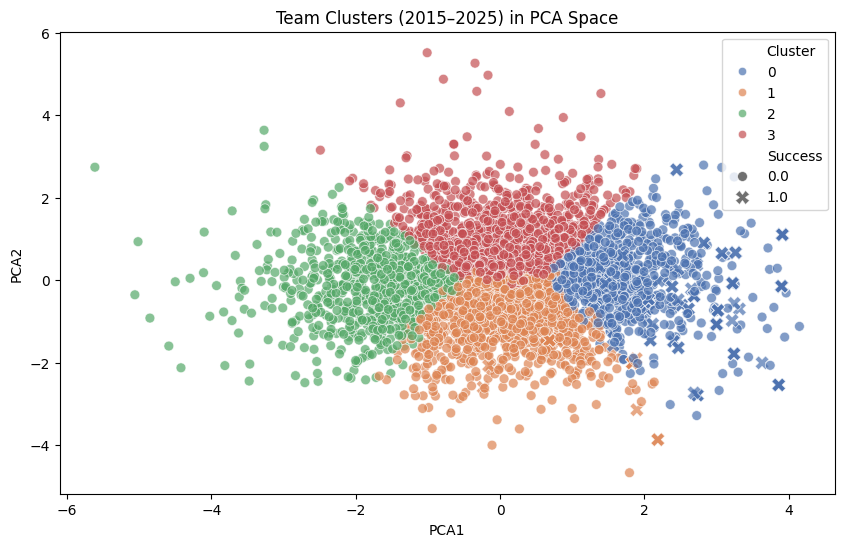

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

era_df = clustered_dfs['2015-2025']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(era_df[metrics])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
era_df['PCA1'] = pca_result[:, 0]
era_df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', 
    y='PCA2', 
    hue='Cluster', 
    style='Success', 
    data=era_df, 
    markers={0: 'o', 1: 'X'}, 
    size='Success',
    sizes={0: 50, 1: 100},
    alpha=0.7,
    palette='deep'
)
plt.title('Team Clusters (2015-2025) in PCA Space')
plt.legend()
plt.savefig('figures/pca_scatter_2015_2025.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

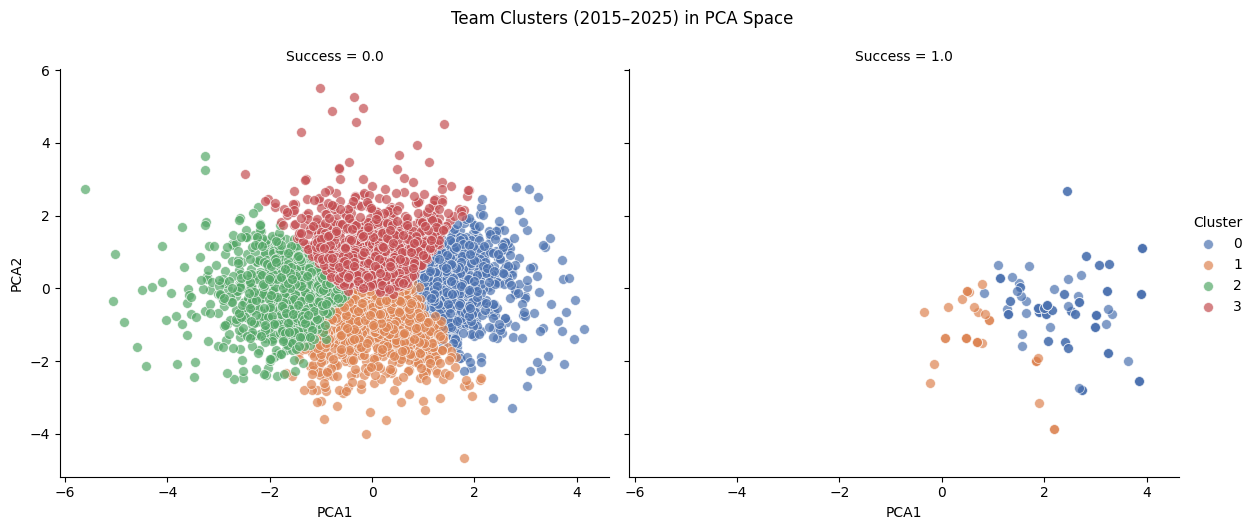

In [ ]:
# Create a faceted scatterplot
g = sns.FacetGrid(era_df, col='Success', hue='Cluster', height=5, aspect=1.2, palette='deep')
g.map(sns.scatterplot, 'PCA1', 'PCA2', alpha=0.7, s=50)
g.add_legend()
g.set_titles('Success = {col_name}')
plt.suptitle('Team Clusters (2015-2025) in PCA Space', y=1.05)
g.savefig('figures/pca_faceted_scatter_2015_2025.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

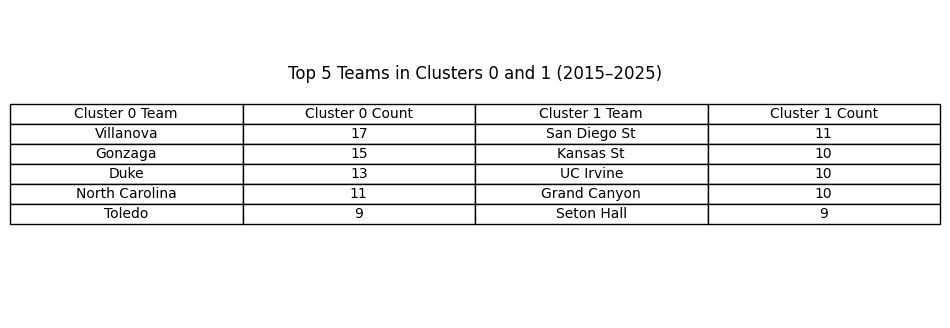

In [ ]:
import pandas as pd

era_df = clustered_dfs['2015-2025']

# Filter for Clusters 0 and 1
cluster0_teams = era_df[era_df['Cluster'] == 0]
cluster1_teams = era_df[era_df['Cluster'] == 1]

# Count how often each team appears
cluster0_top = cluster0_teams['TeamID'].value_counts().head(5)
cluster1_top = cluster1_teams['TeamID'].value_counts().head(5)

# Map TeamID to names (using MTeams.csv)
teams_df = dataframes['MTeams']
cluster0_names = cluster0_top.rename(index=teams_df.set_index('TeamID')['TeamName'])
cluster1_names = cluster1_top.rename(index=teams_df.set_index('TeamID')['TeamName'])

# Create DataFrame for table
table_data = pd.DataFrame({
    'Cluster 0 Team': cluster0_names.index,
    'Cluster 0 Count': cluster0_names.values,
    'Cluster 1 Team': cluster1_names.index,
    'Cluster 1 Count': cluster1_names.values
})

# Plot table
plt.figure(figsize=(10, 4))
plt.axis('off')
table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  loc='center',
                  cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Top 5 Teams in Clusters 0 and 1 (2015-2025)', y=0.75)
plt.savefig('figures/top_teams_2015_2025.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

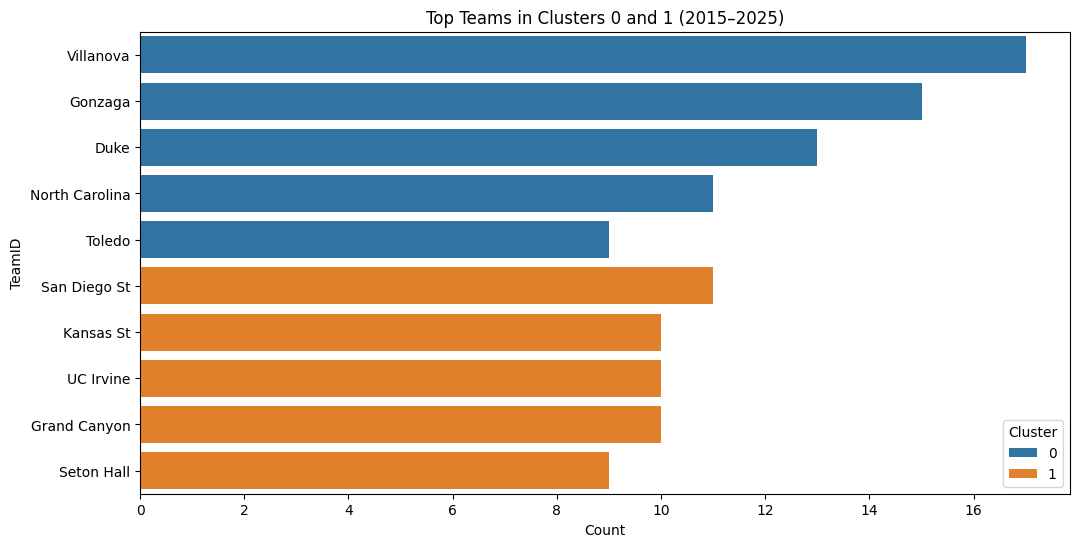

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine top teams for plotting
plot_data = pd.concat([
    cluster0_names.reset_index().rename(columns={'index': 'TeamName', 'count': 'Count'}).assign(Cluster=0),
    cluster1_names.reset_index().rename(columns={'index': 'TeamName', 'count': 'Count'}).assign(Cluster=1)
])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='TeamID', hue='Cluster', data=plot_data)
plt.title('Top Teams in Clusters 0 and 1 (2015-2025)')
plt.savefig('figures/top_teams_barplot_2015_2025.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

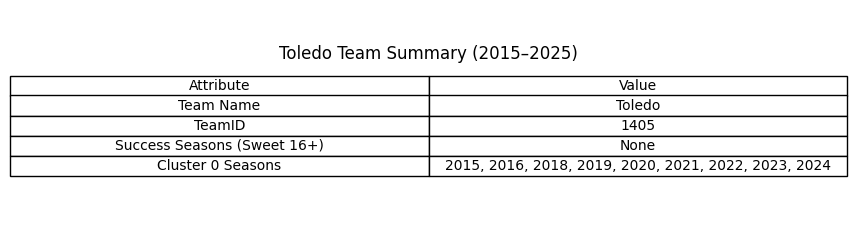

In [ ]:
toledo_row = dataframes['MTeams'].loc[dataframes['MTeams']['TeamName'] == 'Toledo']
toledo_id = 1405
toledo_success = era_df[(era_df['TeamID'] == toledo_id) & (era_df['Success'] == 1)]
success_seasons = toledo_success['Season'].tolist()
success_seasons_str = ', '.join(map(str, success_seasons)) if success_seasons else 'None'

toledo_cluster0_years = era_df[(era_df['TeamID'] == toledo_id) & (era_df['Cluster'] == 0)]['Season'].tolist()
cluster0_seasons_str = ', '.join(map(str, toledo_cluster0_years)) if toledo_cluster0_years else 'None'

# Create DataFrame for table
table_data = pd.DataFrame({
    'Attribute': ['Team Name', 'TeamID', 'Success Seasons (Sweet 16+)', 'Cluster 0 Seasons'],
    'Value': [
        toledo_row['TeamName'].iloc[0],
        toledo_row['TeamID'].iloc[0],
        success_seasons_str,
        cluster0_seasons_str
    ]
})

# Plot table
plt.figure(figsize=(9, 3))
plt.axis('off')
table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  loc='center',
                  cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Toledo Team Summary (2015-2025)', y=0.75)
plt.savefig('figures/toledo_summary_2015_2025.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

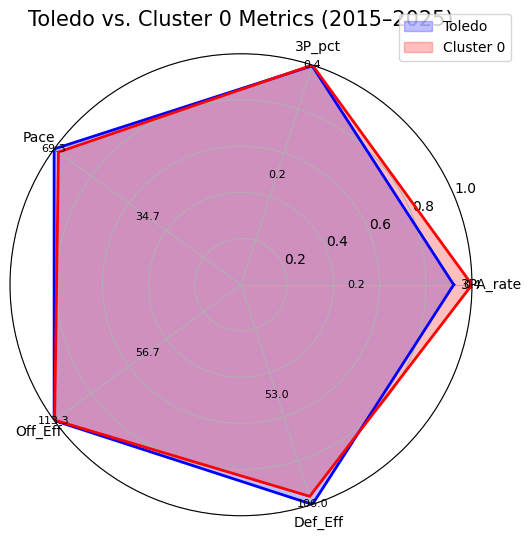

In [ ]:
import plotly.graph_objects as go
import pandas as pd

toledo_metrics = era_df[era_df['TeamID'] == 1405][['3PA_rate', '3P_pct', 'Pace', 'Off_Eff', 'Def_Eff']].mean()

cluster0_centers = pd.DataFrame({
    '3PA_rate': 0.394356, '3P_pct': 0.373478, 'Pace': 67.729034,
    'Off_Eff': 113.012305, 'Def_Eff': 102.124560
}, index=['Cluster 0'])

metrics = ['3PA_rate', '3P_pct', 'Pace', 'Off_Eff', 'Def_Eff']
toledo_vals = toledo_metrics[metrics].values
cluster0_vals = cluster0_centers[metrics].values[0]

max_vals = np.maximum(toledo_vals, cluster0_vals)
toledo_scaled = toledo_vals / max_vals
cluster0_scaled = cluster0_vals / max_vals

# Number of variables
num_vars = len(metrics)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Initialize radar plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

# Plot Toledo (scaled)
toledo_scaled = np.append(toledo_scaled, toledo_scaled[0])
ax.fill(angles, toledo_scaled, color='blue', alpha=0.25, label='Toledo')
ax.plot(angles, toledo_scaled, color='blue', linewidth=2)

# Plot Cluster 0 (scaled)
cluster0_scaled = np.append(cluster0_scaled, cluster0_scaled[0])
ax.fill(angles, cluster0_scaled, color='red', alpha=0.25, label='Cluster 0')
ax.plot(angles, cluster0_scaled, color='red', linewidth=2)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Set radial ticks to show original values
ax.set_ylim(0, 1)
# Customize ticks to show approximate original values
for i, metric in enumerate(metrics):
    # Approximate original values at 0, 0.5, 1
    original_max = max_vals[i]
    ax.text(angles[i], 0.5, f'{original_max/2:.1f}', ha='center', va='center', fontsize=8)
    ax.text(angles[i], 1, f'{original_max:.1f}', ha='center', va='center', fontsize=8)

# Add title and legend
plt.title('Toledo vs. Cluster 0 Metrics (2015-2025)', size=15, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Save to figures/ folder
plt.savefig('figures/toledo_vs_cluster0_radar_2015_2025.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()